In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
import json
import os
import cv2
import numpy as np
from matplotlib.patches import Rectangle
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO

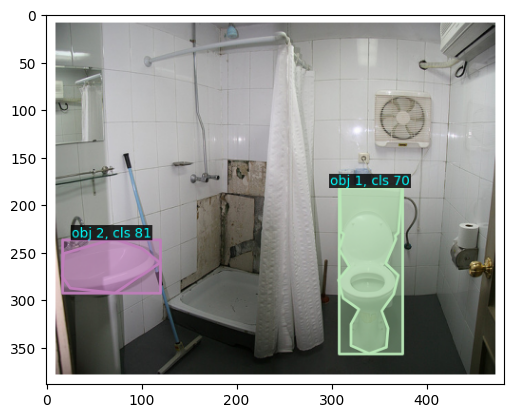

In [3]:
sample = Image.open("sample.jpg")
plt.imshow(sample)

In [3]:
def process_mask(mask):
    
    
    # Get mask
    binary_mask = mask > 0
    mx, my = mask.shape
    overlay = np.zeros((mx,my,3),dtype=np.uint8)
    overlay[binary_mask] = [0, 255, 0]  # Green color for the mask

    # RLE encoding
    rle = coco_mask.encode(np.asfortranarray(binary_mask))
    # Convert `counts` from bytes to string
    rle["counts"] = rle["counts"].decode("utf-8")

    # Decode RLE to calculate area
    area = float(coco_mask.area(rle))

    # Bounding box: [x, y, width, height]
    bbox = coco_mask.toBbox(rle).tolist()

    return rle, area, bbox, overlay

In [18]:


# Function to copy and paste objects from one image to another
def copy_and_paste_objects(src_image, dest_image, src_bboxes, dest_bboxes):
    # Open source and destination images
    src_img = cv2.imread(src_image)
    dest_img = cv2.imread(dest_image)

    for src_bbox, dest_bbox in zip(src_bboxes, dest_bboxes):
        # Extract bounding box dimensions
        src_x, src_y, src_w, src_h = map(int, src_bbox)
        dest_x, dest_y, dest_w, dest_h = map(int, dest_bbox)

        # Crop the object from the source image
        cropped_obj = src_img[src_y:src_y + src_h, src_x:src_x + src_w]

        # Resize the cropped object to match the destination bounding box
        resized_obj = cv2.resize(cropped_obj, (dest_w, dest_h))

        # Paste the resized object onto the destination image
        dest_img[dest_y:dest_y + dest_h, dest_x:dest_x + dest_w] = resized_obj

    return dest_img

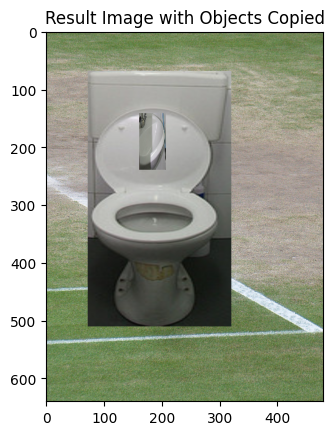

In [19]:


# Paths
annotations_txt = "annotations.txt"

# Load annotations from annotations.txt
annotations = {}
with open(annotations_txt, "r") as f:
    lines = f.readlines()

# Parse annotations into a dictionary keyed by image name
for line in lines[1:]:
    image_name, object_id, category_id, mask_name = line.strip().split(",")
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
    _, _, bbox, _ = process_mask(mask)

    if image_name not in annotations:
        annotations[image_name] = []
    annotations[image_name].append({
        "object_id": int(object_id),
        "category_id": int(category_id),
        "bbox": bbox
    })

# Get bounding boxes for objects 1 and 2 in img1 and objects 3 and 4 in img2
src_image = "img1.jpg"
dest_image = "img2.jpg"
src_bboxes = [ann["bbox"] for ann in annotations[src_image] if ann["object_id"] in [1, 2]]
dest_bboxes = [ann["bbox"] for ann in annotations[dest_image] if ann["object_id"] in [3, 4]]

# Copy and paste objects
result_img = copy_and_paste_objects(src_image, dest_image, src_bboxes, dest_bboxes)

# Show the result
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Result Image with Objects Copied")
plt.show()
